# Final Exam Grade Prediction
This project aims to predict students' final exam grades (G3) using a cleaned dataset from the UCI Machine Learning Repository's [Student Performance Data Set](https://archive.ics.uci.edu/dataset/320/student+performance). The dataset includes various features related to students' academic performance and personal backgrounds. By using basic linear regression, we will be able to predict final exam grades really accurately. This notebook just focuses on the data which has the math exam grades.

You can access to code also from my [Github](https://github.com/UfukTanriverdi8/Mushroom-Classification).

## Importing the dependencies

In [246]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import plotly.graph_objects as go


## Loading the dataset

In [320]:
df = pd.read_csv("student-mat.csv",sep=";")

df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


## Checking for missing values

In [321]:
nan_counts = df.isna().any().any()
print(nan_counts)

False


## Feature Engineering
As you can see there is a lot of different features to choose. At first, we will keep the things simple and just use the grades of the first two exams. After that we can try adding different features to first two grades or we can try to predict the final grade without even using the first two exams.
But before the feature selection, we need to convert the features into numerical values for the model.

### Converting yes/no columns to binary
``schoolsup``, ``famsup``, `paid`, ``activities``, `nursery`, `higher`, `internet`, `romantic` columns are converted to numerical values.

In [322]:
binary_columns = []
for col in df.columns:
    if (df[col][0] == "yes") or (df[col][0] == "no"):
        binary_columns.append(col)
# This will convert yes to 1 and no to 0
for col in binary_columns:
    df[col] = (df[col] == "yes").astype(int)

### Applying one hot encoding to other columns with categorical values
There are some columns which holds categorical values and we can convert them to numerical values with one hot encoding.

In [323]:
df_encoded = pd.get_dummies(df)
df_encoded.head()

,age,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,...,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
0,18,4,4,2,2,0,1,0,0,0,...,False,False,True,True,False,False,False,False,True,False
1,17,1,1,1,2,0,0,1,0,0,...,True,False,False,True,False,False,False,True,False,False
2,15,1,1,1,2,0,1,0,0,0,...,True,False,False,False,False,True,False,False,True,False
3,15,4,2,1,3,0,0,1,0,1,...,False,True,False,False,True,False,False,False,True,False
4,16,3,3,1,2,0,0,1,0,0,...,True,False,False,False,True,False,False,True,False,False


Now after this step our features are ready for our model. Like i said first we will use just the first two grades then we'll experiment a little bit.

In [324]:
features = ["G1", "G2"]
X = df_encoded[features]
y = df_encoded["G3"]

## Splitting the data

In [325]:
def split_data(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)
    return X_train, X_val, y_train, y_val

## Visualization function
We could've used matplotlib but plotly just looks better and also it's easier to plot interactive graphs with plotly. This function will be showing G1, G2, G3 values and also our predictions of G3 values.

In [326]:
def plot3d(X,y,pipeline,features):
    # Create a grid of G1 and G2 values
    G1_range = np.linspace(X['G1'].min(), X['G1'].max(), 50)
    G2_range = np.linspace(X['G2'].min(), X['G2'].max(), 50)
    G1_grid, G2_grid = np.meshgrid(G1_range, G2_range)
    X_grid = pd.DataFrame(np.c_[G1_grid.ravel(), G2_grid.ravel()], columns=features)

    # Predict G3 values for the grid
    G3_pred = pipeline.predict(X_grid)
    G3_grid = G3_pred.reshape(G1_grid.shape)

    # Create the 3D scatter plot of actual data
    scatter = go.Scatter3d(
        x=X['G1'],
        y=X['G2'],
        z=y,
        mode='markers',
        marker=dict(
            size=5,
            color='red',
            opacity=0.8
        ),
        name='Actual Data'
    )

    # Create the surface plot for predictions
    surface = go.Surface(
        x=G1_grid,
        y=G2_grid,
        z=G3_grid,
        colorscale='Viridis',
        opacity=0.7,
        name='Prediction Surface'
    )

    # Combine the plots
    fig = go.Figure(data=[scatter, surface])

    # Update layout
    fig.update_layout(
        title='Interactive 3D Plot of G1, G2, G3 with Prediction Surface',
        scene=dict(
            xaxis_title='G1',
            yaxis_title='G2',
            zaxis_title='G3'
        ),
        width=800,
        height=800
    )


    # Show the plot
    fig.show()

## Training the model
We will just linear regression to predict final grades. You will see that it produces really accurate results. I want to experiment with features rather than trying out different algorithms.

In [327]:
def train_model(X, y, pipeline):
    X_train, X_val, y_train, y_val = split_data(X, y)

    # Fit the model
    pipeline.fit(X_train, y_train)

    # Predict the target values
    y_pred = pipeline.predict(X_val)

    # Define the evaluation metrics
    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    # Perform cross-validation
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')

    # Return the evaluation metrics
    return {
        "Mean Absolute Error": mae,
        "Mean Squared Error": mse,
        "R2 Score": r2,
        "Mean CV R2 Score": np.mean(cv_scores)
    }

In [328]:
# Create a pipeline with StandardScaler and LinearRegression
lr_pipeline = make_pipeline(StandardScaler(), LinearRegression())

In [329]:
results = train_model(X, y, lr_pipeline)
for i in results:
    print(i + ":", results[i])


Mean Absolute Error: 0.9712785591142739
Mean Squared Error: 2.916008171577783
R2 Score: 0.7579731548617765
Mean CV R2 Score: 0.8254860623229753


So as you can see, by just using two features and linear regression we got 0.81 average R2 score. This is pretty good for the first try, let's plot the training data and our predictions. By the way we will be focusing on the mean cross validation R2 scores to evaluate our trainings in this notebook.

In [330]:
plot3d(X, y,lr_pipeline, features)

That is a beautiful graph! You can clearly see our data points and our prediction surface. Also you can notice some outliers too. Apparently some students probably didn't enter the final exam or they somehow scored 0 even though they had some scores from previous exams. Whatever the reason is these outliers are the biggest enemy of linear regression. We should get rid of them and try to run our model again. Remember that we don't have much data so we wouldn't want to just get rid of all points where the G3 grade is 0. We want to just get rid of points where G1 and G2 grades are bigger than zero but G3 grade is zero. The points which have the G3 and G2 grades are zero together should stay. 

In [331]:
# Getting rid of the rows where G3 is 0 but G1 and G2 are not 0
# ~ stand for NOT operation
# If the G3 is 0, G1 is greater than 0 and G2 is greater than 0, then do not include that row
condition = ~((df_encoded["G3"] == 0) & (df_encoded["G1"] > 0) & (df_encoded["G2"] > 0))

# Apply the condition to the dataframe
filtered_df = df_encoded[condition]

# Define features and target variable
X = filtered_df[features]
y = filtered_df["G3"]
results = train_model(X, y, lr_pipeline)
for i in results:
    print(i + ":", results[i])
plot3d(X, y, lr_pipeline, features)

Mean Absolute Error: 0.7144481420382389
Mean Squared Error: 1.3526530585169558
R2 Score: 0.8735279270323595
Mean CV R2 Score: 0.8735935745988085


Big jump from 0.81 to 0.94! Now 0.94 is a really acceptable value but let's try to increase it even more by just including more features into X. We need a correlation heatmap to decide which feature correlates the most with G3 grades.

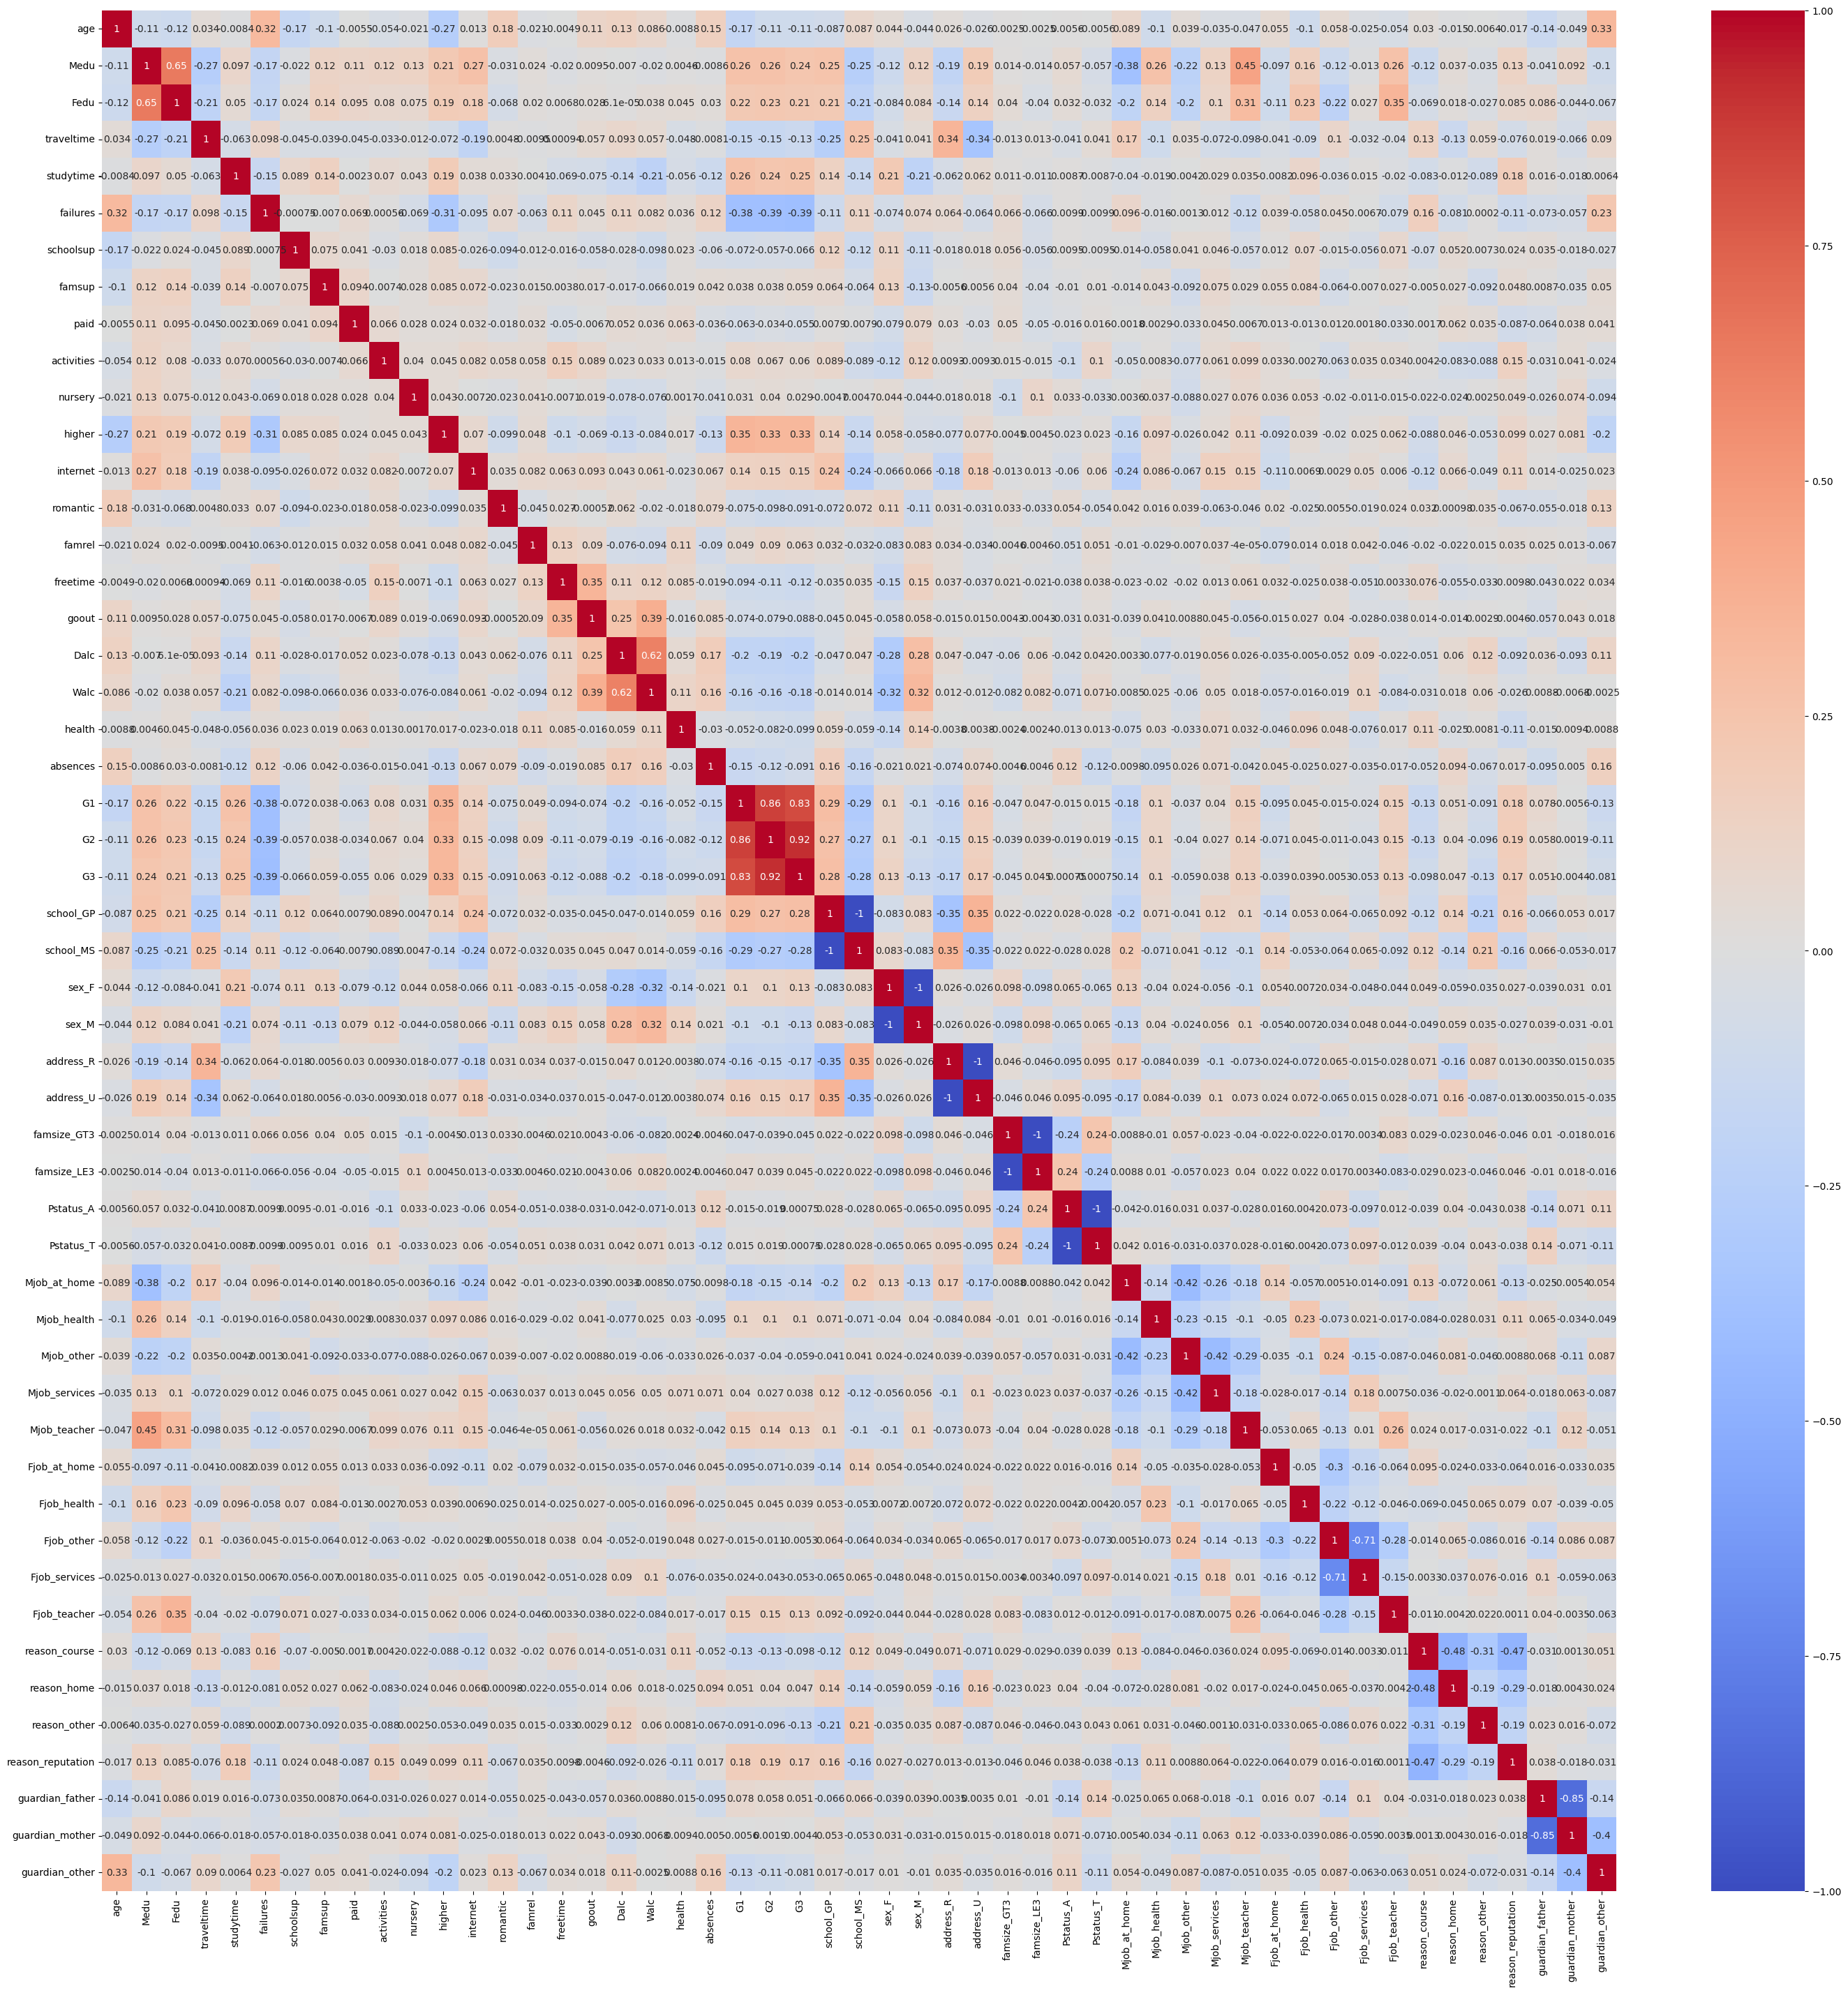

In [332]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation heatmap
plt.figure(figsize=(35, 35))
sns.heatmap(df_encoded.corr(), annot=True,cmap='coolwarm')
plt.show()

Remember that we're not only looking for positive correlations, our focus is on high negative and high positive correlations. After G1 and G3, failures has the best correlation with G3. I stored some highly correlated features in a list. Surprisingly studytime is not in here, in fact it has the same positive correlation as the internet access. This means that the positive increase that more studying could give to your final exam score is the same as the possibility of you having internet access. At least this is the result we obtain from this data.\
We will train our model with each combination we can get from this highly correlated features list.

In [333]:
import itertools 
feature_results = []
high_corr_features = ["failures", "Medu","higher","age","Fedu","goout","romantic"]
for r in range(len(high_corr_features) + 1):
    for combo in itertools.combinations(high_corr_features, r):
        # Create feature list for current combination
        features = ["G1", "G2"] + list(combo)
        X = filtered_df[features]
        y = filtered_df["G3"]

        # Train and evaluate the model
        metrics = train_model(X, y, lr_pipeline)

        # Append the results
        feature_results.append({
            "Features": features,
            "Metrics": metrics
        })

max = 0
for i in range(len(feature_results)):
    if feature_results[i]['Metrics']['R2 Score'] > max:
        max = feature_results[i]['Metrics']['R2 Score']
        best_result = feature_results[i]

print(f"Best features: {best_result['Features']}")
print(f"Best Mean CV R2 score: {best_result['Metrics']['Mean CV R2 Score']:.4f}")


Best features: ['G1', 'G2', 'failures', 'age', 'goout']
Best Mean CV R2 score: 0.8760


And we can see out of all those combinations we can add two G1 and G2 grades, we were just be able to get the most R2 score of 0.9473 which is slightly less than we got when we just used the G1 and G2 grades. As you can see adding extra features didn't increase the accuracy at all. Actually we could've predicted this from the heatmap before, i don't know why but all the features other than G1 and G2 just do not have the enough correlation to help increasing the model accuracy.

Let's try to predict the final grade without using the grades of the past exams. We will not use the filtered_df because that filter was specifically for the past two exams.\
We'll try to train our model with each combination we can get from the highest correlated features other than G1 and G2.

In [334]:
feature_results = []
# Compute the correlation matrix
corr_matrix = df_encoded.corr()

# Extract correlations with the target variable 'G3'
target_corr = corr_matrix["G3"].drop("G3")  # Drop 'G3' to exclude self-correlation

# Sort by absolute correlation values
sorted_corr = target_corr.abs().sort_values(ascending=False)

# Get the top correlated features as a list
features_list = sorted_corr[2:12].index.tolist()
print("\nTop correlated features list:")
print(features_list)
for r in range(len(features_list) + 1):
    for combo in itertools.combinations(features_list, r):
        # Create feature list for current combination
        if len(combo) == 0:
            continue
        features = list(combo)
        X = filtered_df[features]
        y = filtered_df["G3"]

        # Train and evaluate the model
        metrics = train_model(X, y, lr_pipeline)

        # Append the results
        feature_results.append({
            "Features": features,
            "Metrics": metrics
        })

max = 0
for i in range(len(feature_results)): 
    if feature_results[i]['Metrics']['R2 Score'] > max:
        max = feature_results[i]['Metrics']['R2 Score']
        best_result = feature_results[i]

print(f"Best features: {best_result['Features']}")
print(f"Best Mean CV R2 score: {best_result['Metrics']['Mean CV R2 Score']:.4f}")


Top correlated features list:
['failures', 'higher', 'school_GP', 'school_MS', 'studytime', 'Medu', 'Fedu', 'Dalc', 'Walc', 'reason_reputation']
Best features: ['failures', 'higher', 'school_GP', 'Medu', 'Fedu', 'Dalc', 'reason_reputation']
Best Mean CV R2 score: 0.1790


Out of all those possibilites 0.11 was the best we can get. We don't even stand a chance without the information of the past two exams.\
The cause of this may be data inaccuracy. But to sum it all up best we can say is that this dataset is a perfect example to get used to linear regression. Because we need only two features and one target variable, we can easily visualize the prediction and see what is going on. With some tweaks to dataset, we were able to get a satisfying accuracy in the end.